# AML - Assignment 4 - Recurrent Neural Network
## Thanasit

# MODEL 1 - One_hot Model

In [30]:
#!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!rm -rf aclImdb
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

2847.60s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
2855.41s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
2873.01s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [ ]:
import os, pathlib, shutil, random
from tensorflow import keras
batch_size = 32
base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"

for category in ("neg", "pos"):
    os.makedirs(val_dir / category, exist_ok=True)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files)) # total of 5000 samples
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)
text_only_train_ds = train_ds.map(lambda x, y: x)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [32]:
from tensorflow.keras import layers

max_length = 600
max_tokens = 20000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

2024-11-25 02:21:39.119870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [73]:
import tensorflow as tf
inputs = keras.Input(shape=(None,), dtype="int64")

class OneHotEncodingLayer(layers.Layer):
    def __init__(self, depth, **kwargs):
        super().__init__(**kwargs)
        self.depth = depth

    def call(self, inputs):
        return tf.one_hot(inputs, depth=self.depth)

    def compute_output_shape(self, input_shape):
        return input_shape + (self.depth,)

    def get_config(self):
        config = super().get_config()
        config.update({"depth": self.depth})
        return config

embedded = OneHotEncodingLayer(depth=max_tokens)(inputs)

x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ one_hot_encoding_layer          │ (None, None, 20000)    │             0 │
│ (OneHotEncodingLayer)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_16                │ (None, 64)             │     5,128,448 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,128,513 (19.56 MB)

 Trainable params: 5,128,513 (19.56 MB)

 Non-trainable params: 0 (0.00 B)

In [120]:
callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)
]
model_fit = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("one_hot_bidir_lstm.keras", custom_objects={"OneHotEncodingLayer": OneHotEncodingLayer})
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 784s 1s/step - accuracy: 0.9078 - loss: 0.2589 - val_accuracy: 0.8792 - val_loss: 0.2918
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 500s 799ms/step - accuracy: 0.9237 - loss: 0.2249 - val_accuracy: 0.8890 - val_loss: 0.3339
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 492s 786ms/step - accuracy: 0.9331 - loss: 0.1978 - val_accuracy: 0.8818 - val_loss: 0.3141
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 585s 936ms/step - accuracy: 0.9407 - loss: 0.1796 - val_accuracy: 0.8948 - val_loss: 0.2915
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 482s 771ms/step - accuracy: 0.9489 - loss: 0.1520 - val_accuracy: 0.8898 - val_loss: 0.3838
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 503s 804ms/step - accuracy: 0.9544 - loss: 0.1384 - val_accuracy: 0.8802 - val_loss: 0.4447
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 472s 755ms/step - accuracy: 0.9651 - loss: 0.1176 - val_accuracy: 0.8754 - val_loss: 0.4921
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 529s 845ms/step - accuracy: 0.9677 - lo

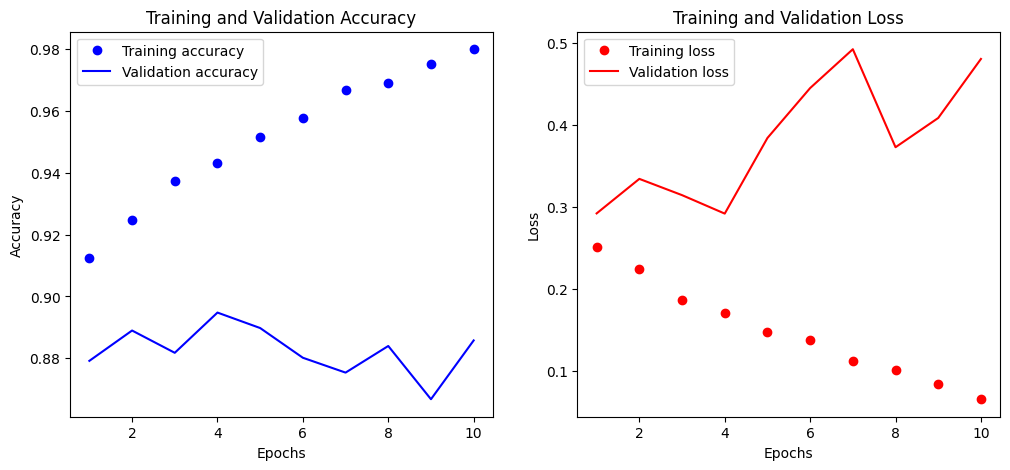

In [121]:
import matplotlib.pyplot as plt
def plot_training_history(model):
    epochs = range(1, len(model.history['accuracy']) + 1)
    
    # Accuracy plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, model.history['accuracy'], 'bo', label='Training accuracy')
    plt.plot(epochs, model.history['val_accuracy'], 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, model.history['loss'], 'ro', label='Training loss')
    plt.plot(epochs, model.history['val_loss'], 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

plot_training_history(model_fit)

# MODEL 2 - Embedded Layers

In [81]:
import os, pathlib, shutil, random
from tensorflow import keras
batch_size2 = 100 # Restrict training samples to 100
base_dir2 = pathlib.Path("aclImdb2")
val_dir2 = base_dir2 / "val"
train_dir2 = base_dir2 / "train"

for category in ("neg", "pos"):
    os.makedirs(val_dir2 / category, exist_ok=True)
    files2 = os.listdir(train_dir2 / category)
    random.Random(1337).shuffle(files)
    num_val_samples2 = 5000 # 5000 for each class, in total of 10000 validation samples
    val_files2 = files2[-num_val_samples2:]
    for fname in val_files2:
        shutil.move(train_dir2 / category / fname,
                    val_dir2 / category / fname)

train_ds2 = keras.utils.text_dataset_from_directory(
    "aclImdb2/train", batch_size=batch_size2
)
val_ds2 = keras.utils.text_dataset_from_directory(
    "aclImdb2/val", batch_size=batch_size2
)
test_ds2 = keras.utils.text_dataset_from_directory(
    "aclImdb2/test", batch_size=batch_size2
)
text_only_train_ds2 = train_ds2.map(lambda x, y: x)

Found 15000 files belonging to 2 classes.
Found 10000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [82]:
from tensorflow.keras import layers

max_length2 = 150
max_tokens2 = 10000
text_vectorization2 = layers.TextVectorization(
    max_tokens=max_tokens2,
    output_mode="int",
    output_sequence_length=max_length2,
)
text_vectorization2.adapt(text_only_train_ds2)

int_train_ds2 = train_ds2.map(
    lambda x, y: (text_vectorization2(x), y),
    num_parallel_calls=4)
int_val_ds2 = val_ds2.map(
    lambda x, y: (text_vectorization2(x), y),
    num_parallel_calls=4)
int_test_ds2 = test_ds2.map(
    lambda x, y: (text_vectorization2(x), y),
    num_parallel_calls=4)

2024-11-25 15:18:12.188399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [83]:
import tensorflow as tf

inputs2 = keras.Input(shape=(None,), dtype="int64")
embedded2 = layers.Embedding(input_dim=max_tokens2, output_dim=100)(inputs2)
x2 = layers.Bidirectional(layers.LSTM(32))(embedded2)
x2 = layers.Dropout(0.5)(x2)
outputs2 = layers.Dense(1, activation="sigmoid")(x2)
model2 = keras.Model(inputs2, outputs2)
model2.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model2.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)     │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_22 (Embedding)        │ (None, None, 100)      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_22                │ (None, 64)             │        34,048 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,034,113 (3.94 MB)

 Trainable params: 1,034,113 (3.94 MB)

 Non-trainable params: 0 (0.00 B)

In [107]:
callbacks2 = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.keras",
                                    save_best_only=True)
]
model2_fit = model2.fit(int_train_ds2, validation_data=int_val_ds2, epochs=10, callbacks=callbacks2)
model2 = keras.models.load_model("embeddings_bidir_gru.keras")
print(f"Test acc: {model2.evaluate(int_test_ds2)[1]:.3f}")

Epoch 1/10


150/150 ━━━━━━━━━━━━━━━━━━━━ 27s 166ms/step - accuracy: 0.8930 - loss: 0.2763 - val_accuracy: 0.8424 - val_loss: 0.4069
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 24s 158ms/step - accuracy: 0.9007 - loss: 0.2543 - val_accuracy: 0.8112 - val_loss: 0.4796
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 25s 164ms/step - accuracy: 0.9175 - loss: 0.2288 - val_accuracy: 0.8425 - val_loss: 0.3920
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 23s 156ms/step - accuracy: 0.9208 - loss: 0.2163 - val_accuracy: 0.8176 - val_loss: 0.4623
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 24s 157ms/step - accuracy: 0.9317 - loss: 0.1865 - val_accuracy: 0.8212 - val_loss: 0.4144
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 23s 154ms/step - accuracy: 0.9395 - loss: 0.1715 - val_accuracy: 0.8411 - val_loss: 0.4379
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 23s 156ms/step - accuracy: 0.9541 - loss: 0.1324 - val_accuracy: 0.8283 - val_loss: 0.4205
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 23s 154ms/step - accuracy: 0.9606 - loss: 0.1213 - val

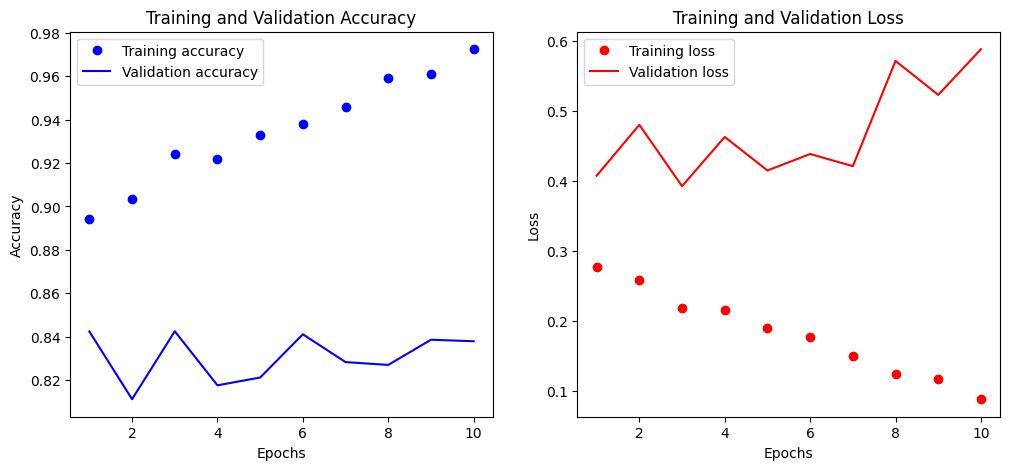

In [108]:
import matplotlib.pyplot as plt
def plot_training_history(model):
    epochs = range(1, len(model.history['accuracy']) + 1)
    
    # Accuracy plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, model.history['accuracy'], 'bo', label='Training accuracy')
    plt.plot(epochs, model.history['val_accuracy'], 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, model.history['loss'], 'ro', label='Training loss')
    plt.plot(epochs, model.history['val_loss'], 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

plot_training_history(model2_fit)

# MODEL 3 - Pre-trained GLOVE Word Embedded

In [42]:
!rm -f glove.6B.zip
!curl -O http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   308  100   308    0     0   2318      0 --:--:-- --:--:-- --:--:--  2333
[glove.6B.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of glove.6B.zip or
        glove.6B.zip.zip, and cannot find glove.6B.zip.ZIP, period.


In [85]:
import numpy as np
path_to_glove_file3 = "glove/glove.6B.100D.txt"

embeddings_index3 = {}
with open(path_to_glove_file3) as f:
    for line in f:
        word3, coefs3 = line.split(maxsplit=1)
        coefs3 = np.fromstring(coefs3, "f", sep=" ")
        embeddings_index3[word3] = coefs3

print(f"Found {len(embeddings_index3)} word vectors.")

Found 400000 word vectors.


In [86]:
embedding_dim3 = 100

vocabulary3 = text_vectorization2.get_vocabulary()
word_index3 = dict(zip(vocabulary3, range(len(vocabulary3))))

embedding_matrix3 = np.zeros((max_tokens2, embedding_dim3))
for word3, i in word_index3.items():
    if i < max_tokens2:
        embedding_vector3 = embeddings_index3.get(word3)
    if embedding_vector3 is not None:
        embedding_matrix3[i] = embedding_vector3

In [87]:
embedding_layer3 = layers.Embedding(
    max_tokens2,
    embedding_dim3,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix3),
    trainable=False,
    mask_zero=True,
)

In [113]:
inputs3 = keras.Input(shape=(None,), dtype="int64")
embedded3 = embedding_layer3(inputs3)
x3 = layers.Bidirectional(layers.LSTM(32))(embedded3)
x3 = layers.Dropout(0.5)(x3)
outputs3 = layers.Dense(1, activation="sigmoid")(x3)
model3 = keras.Model(inputs3, outputs3)
model3.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model3.summary()

callbacks3 = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
                                    save_best_only=True),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    )
]
model3_fit = model3.fit(int_train_ds2, validation_data=int_val_ds2, epochs=30, callbacks=callbacks3)
model3 = keras.models.load_model("glove_embeddings_sequence_model.keras")
print(f"Test acc: {model3.evaluate(int_test_ds2)[1]:.3f}")

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_38      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_23        │ (None, None, 100) │  1,000,000 │ input_layer_38[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_40        │ (None, None)      │          0 │ input_layer_38[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_45    │ (None, 64)        │     34,048 │ embedding_23[3][… │
│ (Bidirectional)     │                   │            │ not_equal_40[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_37          │ (None, 64)        │          0 │ bidirectional_45… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 1)         │         65 │ dropout_37[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,034,113 (3.94 MB)

 Trainable params: 34,113 (133.25 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step - accuracy: 0.5384 - loss: 0.6897 - val_accuracy: 0.5722 - val_loss: 0.7020
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.6694 - loss: 0.6152 - val_accuracy: 0.7219 - val_loss: 0.5580
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 132ms/step - accuracy: 0.7279 - loss: 0.5537 - val_accuracy: 0.5698 - val_loss: 0.8491
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.7451 - loss: 0.5286 - val_accuracy: 0.7690 - val_loss: 0.4924
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.7726 - loss: 0.4899 - val_accuracy: 0.7772 - val_loss: 0.4787
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.7783 - loss: 0.4807 - val_accuracy: 0.7843 - val_loss: 0.4634
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.7969 - loss: 0.4509 - val_accuracy: 0.7857 - val_loss: 0.4553
Epoch 8/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.8018 - loss: 0

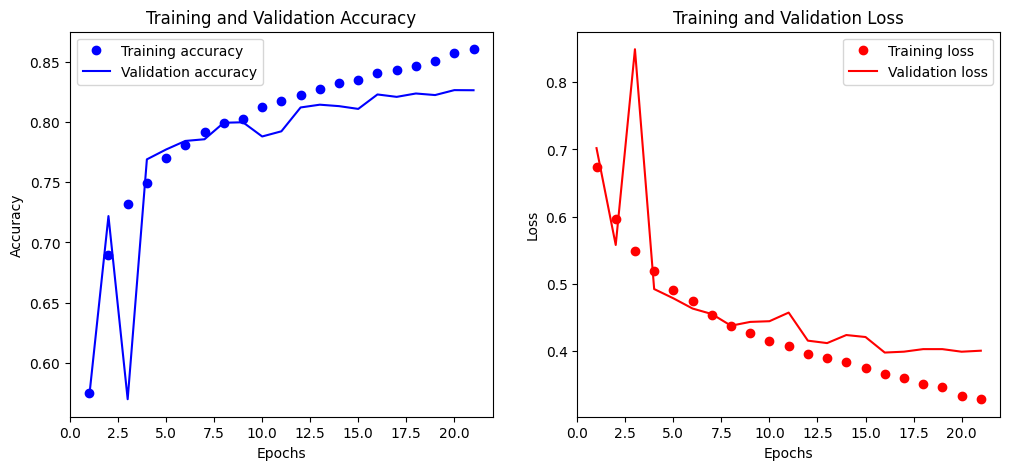

In [114]:
import matplotlib.pyplot as plt
def plot_training_history(model):
    epochs = range(1, len(model.history['accuracy']) + 1)
    
    # Accuracy plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, model.history['accuracy'], 'bo', label='Training accuracy')
    plt.plot(epochs, model.history['val_accuracy'], 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, model.history['loss'], 'ro', label='Training loss')
    plt.plot(epochs, model.history['val_loss'], 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

plot_training_history(model3_fit)

# MODEL 4 - Adjusted Pre-trained Word Embeded

In [115]:
import numpy as np
path_to_glove_file4 = "glove/glove.6B.100D.txt"

embeddings_index4 = {}
with open(path_to_glove_file4) as f:
    for line in f:
        word4, coefs4 = line.split(maxsplit=1)
        coefs4 = np.fromstring(coefs4, "f", sep=" ")
        embeddings_index4[word4] = coefs4

print(f"Found {len(embeddings_index4)} word vectors.")

Found 400000 word vectors.


In [116]:
embedding_dim4 = 100

vocabulary4 = text_vectorization.get_vocabulary()
word_index4 = dict(zip(vocabulary4, range(len(vocabulary4))))

embedding_matrix4 = np.zeros((max_tokens, embedding_dim4))
for word4, i in word_index4.items():
    if i < max_tokens:
        embedding_vector4 = embeddings_index4.get(word4)
    if embedding_vector4 is not None:
        embedding_matrix4[i] = embedding_vector4

In [117]:
embedding_layer4 = layers.Embedding(
    max_tokens,
    embedding_dim4,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix4),
    trainable=False,
    mask_zero=True,
)

In [118]:
inputs4 = keras.Input(shape=(None,), dtype="int64")
embedded4 = embedding_layer4(inputs4)
x4 = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(embedded4)
x4 = layers.Bidirectional(layers.LSTM(128))(x4)
x4 = layers.Dropout(0.3)(x4)
x4 = layers.BatchNormalization()(x4)
outputs4 = layers.Dense(1, activation="sigmoid", kernel_regularizer=keras.regularizers.l2(0.001))(x4)
model4 = keras.Model(inputs4, outputs4)
model4.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss="binary_crossentropy",
              metrics=["accuracy"])
model4.summary()

callbacks4 = [
    keras.callbacks.ModelCheckpoint("adj_glove_embeddings_sequence_model.keras",
                                    save_best_only=True),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    )
]
model4_fit = model4.fit(int_train_ds, validation_data=int_val_ds, epochs=20, callbacks=callbacks4)
model4 = keras.models.load_model("adj_glove_embeddings_sequence_model.keras")
print(f"Test acc: {model4.evaluate(int_test_ds)[1]:.3f}")

Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_39      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_25        │ (None, None, 100) │  2,000,000 │ input_layer_39[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_42        │ (None, None)      │          0 │ input_layer_39[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_46    │ (None, None, 128) │     84,480 │ embedding_25[0][… │
│ (Bidirectional)     │                   │            │ not_equal_42[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_47    │ (None, 256)       │    263,168 │ bidirectional_46… │
│ (Bidirectional)     │                   │            │ not_equal_42[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_38          │ (None, 256)       │          0 │ bidirectional_47… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dropout_38[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 1)         │        257 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,348,929 (8.96 MB)

 Trainable params: 348,417 (1.33 MB)

 Non-trainable params: 2,000,512 (7.63 MB)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 188s 294ms/step - accuracy: 0.5089 - loss: 0.7316 - val_accuracy: 0.4958 - val_loss: 0.7017
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 183s 293ms/step - accuracy: 0.5090 - loss: 0.7140 - val_accuracy: 0.5004 - val_loss: 0.6970
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 184s 295ms/step - accuracy: 0.5053 - loss: 0.7011 - val_accuracy: 0.5112 - val_loss: 0.6937
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 183s 293ms/step - accuracy: 0.5046 - loss: 0.6935 - val_accuracy: 0.5132 - val_loss: 0.6927
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 183s 293ms/step - accuracy: 0.5156 - loss: 0.6871 - val_accuracy: 0.5068 - val_loss: 0.6879
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 182s 291ms/step - accuracy: 0.5214 - loss: 0.6799 - val_accuracy: 0.5064 - val_loss: 0.7105
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 183s 293ms/step - accuracy: 0.5469 - loss: 0.6670 - val_accuracy: 0.7260 - val_loss: 0.6351
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 183s 292ms/step - accuracy: 0.6889 -

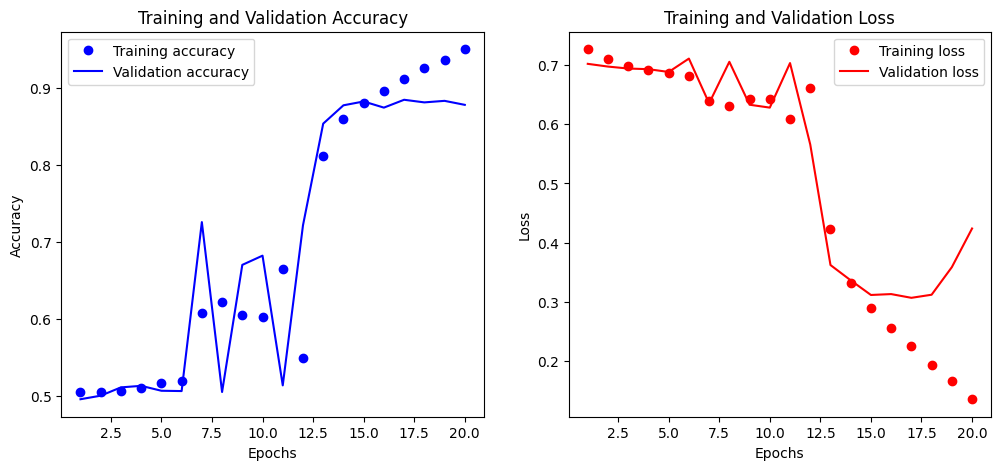

In [119]:
import matplotlib.pyplot as plt
def plot_training_history(model4):
    epochs = range(1, len(model4.history['accuracy']) + 1)
    
    # Accuracy plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, model4.history['accuracy'], 'bo', label='Training accuracy')
    plt.plot(epochs, model4.history['val_accuracy'], 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, model4.history['loss'], 'ro', label='Training loss')
    plt.plot(epochs, model4.history['val_loss'], 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

plot_training_history(model4_fit)

# Summary

In [124]:
import pandas as pd

# Define the data
data = {
    "Model Name": ["Model 1 - One_Hot", "Model 2 - Embedded Layer", "Model 3 - GLOVE Word Embbeded", "Model 4 - Adjust GLOVE Word Embedded"],
    "Word Length": [600, 150, 150, 150],
    "Top Words": [20000, 10000, 10000, 20000],
    "Training Size": [20000, 15000, 15000, 15000],
    "Validation Size": [5000, 10000, 10000, 10000],
    "Testing Size": [25000, 25000, 25000, 25000],
    "Model": ["One Hot", "Embedded", "Pre-trained Embedded", "Pre-trained Embedded"],
    "Number of Hidden Layers": [1, 1, 1, 2],
    "Highest Number of Nodes": [32, 32, 32, 128],
    "validation Loss": ["0.2915", "0.3920", "0.3980", "0.370"],
    "Validation Accuracy": ["89.48%", "84.25%", "82.29%", "88.5%"],
    "Testing Accuracy": ["88.0%", "82.9%", "82.5%", "87.7%"],
    "Epochs": [4, 4, 16, 17]
}

# Create the DataFrame and set "Model" as the index, then transpose
df = pd.DataFrame(data).set_index("Model Name").T

# Style the transposed DataFrame for display
styled_df = df.style.set_table_styles(
    [{'selector': 'thead th', 'props': [('background-color', '#4F81BD'), ('color', 'white'), ('font-weight', 'bold')]},
     {'selector': 'tbody td', 'props': [('padding', '8px'), ('border', '1px solid #DDDDDD')]}]
).set_properties(**{
    'text-align': 'center',
    'border-collapse': 'collapse'
}).set_caption("Model Comparison Table").format(precision=0)

styled_df

Model Name,Model 1 - One_Hot,Model 2 - Embedded Layer,Model 3 - GLOVE Word Embbeded,Model 4 - Adjust GLOVE Word Embedded
Word Length,600,150,150,150
Top Words,20000,10000,10000,20000
Training Size,20000,15000,15000,15000
Validation Size,5000,10000,10000,10000
Testing Size,25000,25000,25000,25000
Model,One Hot,Embedded,Pre-trained Embedded,Pre-trained Embedded
Number of Hidden Layers,1,1,1,2
Highest Number of Nodes,32,32,32,128
validation Loss,0.2915,0.3920,0.3980,0.370
Validation Accuracy,89.48%,84.25%,82.29%,88.5%
